# Tuning BM25 parameters

We tune BM25 parameters on a per-field basis including doc2query expansions and bigrammed text fields. These values are used later when optimizing more complex queries.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev_templated, optimize_bm25_mrr100_templated, set_bm25_params
from qopt.optimize import Config, set_bm25_parameters

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
es = Elasticsearch('http://localhost:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 10

index = 'msmarco-document.doc2query'
template_id = 'query'

# no query params
query_params = {}

# field names
field_names = [
    'url',
    'title', 'title.bigrams',
    'body', 'body.bigrams',
    'expansions', 'expansions.bigrams'
]
similarity_names = [f"bm25-{x.replace('.', '-')}" for x in field_names]
similarity_name_by_field = { field: similarity for field, similarity in zip(field_names, similarity_names) }

# default Elasticsearch BM25 params
default_bm25_params = {'k1': 1.2, 'b': 0.75}

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

def reset_all():
    for similarity in similarity_names:
        set_bm25_parameters(es, index, name=similarity, **default_bm25_params)

def for_all_fields(message, fn, existing_results=None):
    _results = {}
    for field, similarity in zip(field_names, similarity_names):
        print(f"{message}: {field}")
        if not existing_results:
            params = default_bm25_params
        else:
            params = existing_results[field][1]
        set_bm25_parameters(es, index, name=similarity, **params)

        _templates = deepcopy(base_templates)
        _templates[0]['template']['source']['query']['match'] = { field: { "query": "{{query_string}}" } }
        _results[field] = fn(_templates, similarity)
    return _results

## Baseline evaluation

In [5]:
%%time

_ = for_all_fields(
    "Dev set evaluation",
    fn=lambda templates, similarity: evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, templates, template_id, query_params),
)

Dev set evaluation: url
Evaluation with: MRR@100
Score: 0.2094
Dev set evaluation: title
Evaluation with: MRR@100
Score: 0.2298
Dev set evaluation: title.bigrams
Evaluation with: MRR@100
Score: 0.1295
Dev set evaluation: body
Evaluation with: MRR@100
Score: 0.2568
Dev set evaluation: body.bigrams
Evaluation with: MRR@100
Score: 0.2015
Dev set evaluation: expansions
Evaluation with: MRR@100
Score: 0.3081
Dev set evaluation: expansions.bigrams
Evaluation with: MRR@100
Score: 0.2837
CPU times: user 15.5 s, sys: 4.3 s, total: 19.8 s
Wall time: 13min 45s


## Optimization

In [8]:
%%time

results = for_all_fields(
    "Optimization",
    fn=lambda templates, similarity: optimize_bm25_mrr100_templated(es, max_concurrent_searches, index, templates, template_id, query_params,
        config_space=Config.parse({
            'method': 'bayesian',
            'num_iterations': 40,
            'num_initial_points': 20,
            'space': {
                'k1': { 'low': 0.0, 'high': 5.0 },
                'b': { 'low': 0.3, 'high': 1.0 },
            }
        }),
        name=similarity),
)

Optimization: url
Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 2/40, took 0:00:41 (remains: 0:26:15)
   | 0.2013 (best: 0.2013) - {'k1': 0.9, 'b': 0.4}
 > iteration 3/40, took 0:00:07 (remains: 0:04:37)
   | 0.1628 (best: 0.2013) - {'k1': 4.852865942208587, 'b': 0.7163140168823129}
 > iteration 4/40, took 0:00:15 (remains: 0:09:32)
   | 0.1750 (best: 0.2013) - {'k1': 3.3057280864331884, 'b': 0.620864753693963}
 > iteration 5/40, took 0:00:08 (remains: 0:04:47)
   | 0.1724 (best: 0.2013) - {'k1': 3.35005017291138, 'b': 0.7072841815045436}
 > iteration 6/40, took 0:00:13 (remains: 0:07:54)
   | 0.2030 (best: 0.2030) - {'k1': 0.7324371094757943, 'b': 0.4905334540408872}
 > iteration 7/40, took 0:00:15 (remains: 0:08:33)
   | 0.1719 (best: 0.2030) - {'k1': 3.5708710761828892, 'b': 0.7006802871661968}
 > iteration 8/40, took 0:00:08 (remains: 0:04:31)
   | 0.1751 

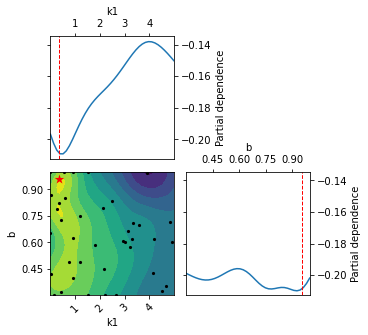

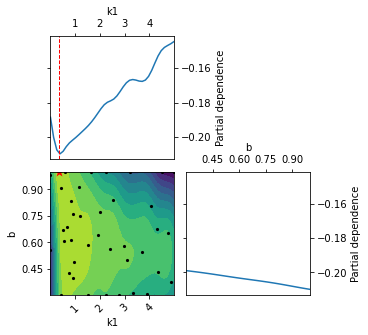

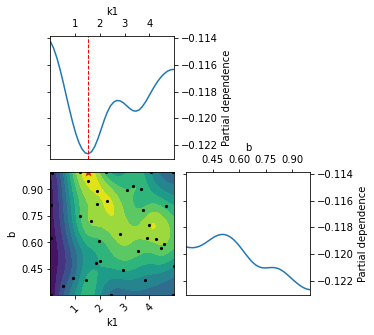

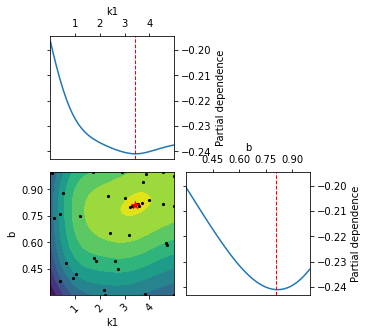

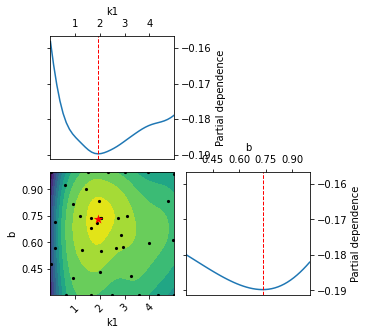

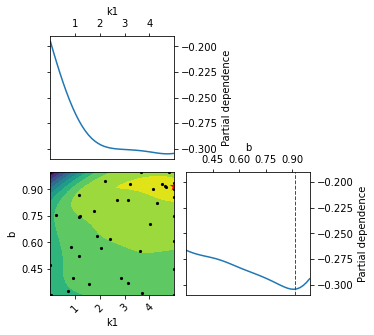

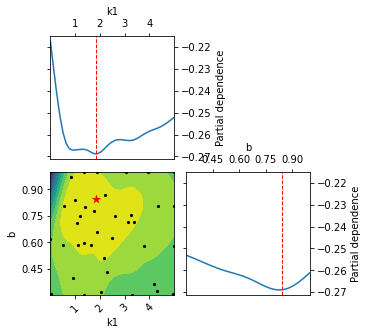

In [9]:
for field, (_, _, _, metadata) in results.items():
    _ = plot_objective(metadata, sample_source='result')

In [10]:
%%time

_ = for_all_fields(
    "Dev set evaluation",
    fn=lambda templates, similarity: evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, templates, template_id, query_params),
    existing_results=results,
)

Dev set evaluation: url
Evaluation with: MRR@100
Score: 0.2201
Dev set evaluation: title
Evaluation with: MRR@100
Score: 0.2354
Dev set evaluation: title.bigrams
Evaluation with: MRR@100
Score: 0.1272
Dev set evaluation: body
Evaluation with: MRR@100
Score: 0.2643
Dev set evaluation: body.bigrams
Evaluation with: MRR@100
Score: 0.2045
Dev set evaluation: expansions
Evaluation with: MRR@100
Score: 0.3213
Dev set evaluation: expansions.bigrams
Evaluation with: MRR@100
Score: 0.2832
CPU times: user 14.1 s, sys: 3.68 s, total: 17.8 s
Wall time: 13min 6s


## Best parameters

In [11]:
best_params = [(x, best) for x, (_, best, _, _) in results.items()]

In [12]:
best_params

[('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}),
 ('title', {'k1': 0.34885436112727763, 'b': 1.0}),
 ('title.bigrams', {'k1': 1.5077266504072955, 'b': 1.0}),
 ('body', {'k1': 3.4418843002060036, 'b': 0.8106120134638413}),
 ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}),
 ('expansions', {'k1': 5.0, 'b': 0.9190886566031851}),
 ('expansions.bigrams', {'k1': 1.8413006685653024, 'b': 0.8445599330786397})]

In [14]:
set_bm25_params(es, index, best_params)

Setting best params for each field
Setting BM25 params fields:
 - url: {'k1': 0.33066956222950633, 'b': 0.9589101032169087}
 - title: {'k1': 0.34885436112727763, 'b': 1.0}
 - title.bigrams: {'k1': 1.5077266504072955, 'b': 1.0}
 - body: {'k1': 3.4418843002060036, 'b': 0.8106120134638413}
 - body.bigrams: {'k1': 1.9100199633100623, 'b': 0.7336619962002098}
 - expansions: {'k1': 5.0, 'b': 0.9190886566031851}
 - expansions.bigrams: {'k1': 1.8413006685653024, 'b': 0.8445599330786397}


## Conclusion

If you'd like to reset all parameters to their defaults, you can do so with the following code. However if you want to stick with the optimal values as shown above, you should skip running this.

In [15]:
reset_all()

In [17]:
# best params from all previous runs with current fields and analyzers

[
    ('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}), # 0.2201
    ('title', {'k1': 0.34885436112727763, 'b': 1.0}), # 0.2354
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}), # 0.1295
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}), # 0.2645
    ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}), # 0.2045
    ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}), # 0.3220
    ('expansions.bigrams', {'k1': 1.2, 'b': 0.75}) # 0.2837
]

[('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}),
 ('title', {'k1': 0.34885436112727763, 'b': 1.0}),
 ('title.bigrams', {'k1': 1.2, 'b': 0.75}),
 ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}),
 ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}),
 ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}),
 ('expansions.bigrams', {'k1': 1.2, 'b': 0.75})]